# 实验介绍

首先介绍这次实验会用到的 **Semeval数据集**——网络公开的短文本情感信息数据集

每一行即一篇文本，下面是其中的一条例子：

```python
1	all:148 anger:22 disgust:2 fear:60 joy:0 sad:64 surprise:0	mortar assault leav at least dead
```

每一行由下面的三项组成：

- 文本编号，与下一项以tab键分隔

- 总情感权值以及各情感权重，与下一项以tab键分隔

- 文本内容，单词之间以空格分隔

这次实验的任务为：

- 1、将数据集“semeval”的数据表示成 One-hot 矩阵，TF矩阵，TF-IDF矩阵，并分别保存为“onehot.txt”，“TF.txt”，“TFIDF.txt”三个文件。

- 2、将数据集的One-hot 矩阵表示成三元组矩阵，保存为“smatrix.txt”文件。

- 3、实现稀疏矩阵加法运算。

## 导入semeval数据集和包含所有不重复的词的list

In [4]:
semeval = []
allWords_semeval = []
with open('semeval', 'r', encoding='utf-8') as f:
    for i in f.readlines():
        #得到每一行的文本数据并按照空格切分为单词
        text = i.split('\t')[2].split(' ')
        #去除最后一个单词的换行符
        text[-1] = text[-1].strip('\n')  
        semeval.append(text) 
        for word in text:
            #若该词未出现过，则将其添加到allWords中
            if word.lower() not in allWords_semeval: 
                #将词转换成小写来进行判断，以防出现A和a不分的情况
                allWords_semeval.append(word.lower()) 
                
print("semeval文件总数：", len(semeval))
print("不重复的词的总数：", len(allWords_semeval))

semeval文件总数： 1246
不重复的词的总数： 2749


## 数据预览

In [10]:
allWords_semeval[0:9]
semeval[0:9]

['mortar', 'assault', 'leav', 'at', 'least', 'dead', 'goal', 'delight', 'for']

[['mortar', 'assault', 'leav', 'at', 'least', 'dead'],
 ['goal', 'delight', 'for', 'sheva'],
 ['nigeria', 'hostag', 'fear', 'dead', 'is', 'freed'],
 ['bomber', 'kill', 'shopper'],
 ['veget', 'not', 'fruit', 'slow', 'brain', 'declin'],
 ['pm', 'havana', 'deal', 'a', 'good', 'experi'],
 ['kate', 'is', 'marri', 'doherti'],
 ['nasa', 'revisit', 'life', 'on', 'mar', 'question'],
 ['happi', 'birthdai', 'ipod']]


#  实验原理

为了更加形象地解释下面所介绍的概念，这里给出如下的一个测试数据集以供测试。

```java
 文本编号  |           词汇表            
 --------------------------------------
 训练文本1 | 苹果 手机 好用 销售          
 训练文本2 | 市民 买   手机 手机          
 训练文本3 | 市民 觉得 苹果 手机 贵   好用
```
这次实验有如下的标准输出要求：**不重复词向量中的列对应的词汇是按照出现顺序构成的。**

在这个例子中词汇的出现顺序则是：苹果、手机、好用、销售、市民、买、觉得、贵。

## 导入测试数据集

为了测试代码的正确性，这里也将测试数据集保存到一个list中，以供后续测试。

In [71]:
testDataSet =[['苹果', '手机', '好用', '销售'],
              ['市民', '买', '手机', '手机'],
              ['市民', '觉得', '苹果', '手机', '贵', '好用']]
allWords_test = ['苹果', '手机', '好用', '销售', '市民', '买', '觉得', '贵']

## One-hot 矩阵

One-hot：使用一个向量表示一篇文章，向量的长度为词汇表的大小。1表示存在对应的单词，0表示不存在。

对于上面的测试数据集，One-hot矩阵则为：

```java
 文本编号  |苹果 手机 好用 销售 市民 买  觉得 贵
 --------------------------------------------
 训练文本1 | 1    1    1    1   0   0   0   0
 训练文本2 | 0    1    0    0   1   1   0   0
 训练文本3 | 1    1    1    0   1   0   1   1
```

### 代码实现及测试

In [58]:
def getOneHot(dataSet, allWords):
    '''得到输入数据集的one-hot矩阵'''
    oneHot=[]
    for index, doc in enumerate(dataSet):
        oneHot.append([])
        for word in allWords:
            if word in doc:
                oneHot[index].append(1)
            else: 
                oneHot[index].append(0)
    return oneHot
oneHot_test = getOneHot(testDataSet, allWords_test)
oneHot_test

[[1, 1, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0], [1, 1, 1, 0, 1, 0, 1, 1]]

从上面的输出可以看到，得到one-hot的函数实现无误，输出与预期一致。

### 将semeval数据集表示成one-hot矩阵

In [120]:
def saveDataToFile(data, fileName):
    '''保存数据到文件中'''
    with open(fileName, 'w', encoding='utf-8') as f:
        for i in data:
            #直接将list类型的元素保存到文件比双重循环写文件更快
            _ = f.write(str(i)+'\n')
    
oneHot_semeval = getOneHot(semeval, allWords_semeval)
saveDataToFile(oneHot_semeval, 'onehot.txt')


## TF矩阵

在一份给定的文件里，**词频（term frequency，TF）**指的是某一个给定的**词语**在该文件中出现的**频率**（这个数字是**对词数(term count)的归一化**，以防止它偏向词数较多的文件，一个词语在词数较多的文件里可能会比词数较少的文件有更高的词数，而不管该词语重要与否）。对于在某一特定文件里的词语 $t_i$ 来说，它的词频可表示为：
        $$ tf_{i,j} = \frac{n_{i,j}}{\sum_kn_{k,j}} $$
其中分子$n_{i,j}$是词$t_i$在文档$d_j$出现的次数，分母$\sum_kn_{k,j}$是文档$d_j$中所有词出现的次数。

通过分析上面的式子，可以发现若词T在文档D中的词频（注意已经是对词数进行**归一化**的结果）越高，那么从某种程度上来讲，可以说词T在文档D中是比较重要的，但是这样的思路有一个bug，那就是这样计算下来，一些对文档来说重要性几乎为0的常用词（或在这个文档集合中经常出现的词）的TF值却很高。下面介绍的IDF矩阵就是为了解决这个问题而引入的。

对于上面的测试数据集，TF矩阵则为：

```java
 文本编号  |苹果 手机 好用 销售 市民 买  觉得 贵
 --------------------------------------------
 训练文本1 |1/4  1/4  1/4  1/4  0   0   0   0
 训练文本2 | 0   1/2   0    0  1/4  1/4 0   0
 训练文本3 |1/6  1/6  1/6   0  1/6  0   1/6 1/6
```
### 代码实现及测试

In [74]:
from collections import Counter

def getTF(dataSet, allWords):
    '''得到输入数据集的TF矩阵'''
    TF=[]
    for index, doc in enumerate(dataSet):
        TF.append([])
        wordCounter = Counter(doc)
        for word in allWords:
            TF[index].append(wordCounter.get(word,0)/len(doc))
    return TF

TF_test = getTF(testDataSet, allWords_test)
TF_test

[[0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.5, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0],
 [0.16666666666666666,
  0.16666666666666666,
  0.16666666666666666,
  0.0,
  0.16666666666666666,
  0.0,
  0.16666666666666666,
  0.16666666666666666]]

从上面的输出可以看到，得到TF的函数实现无误，输出与预期一致。

### 将semeval数据集表示成TF矩阵

In [95]:
TF_semeval = getTF(semeval, allWords_semeval)
saveDataToFile(TF_semeval, 'tf.txt')

## TF-IDF矩阵

对于词$t_i$，其**逆向文件频率(inverse document frequency，IDF) —— $idf_i$**为：总文件数目$|D|$除以包含该词语的文件的数目$|j:t_i\in d_j|$得到的商取对数的结果，即：$$idf_i=log \frac{|D|}{|j:t_i\in d_j|}$$

这里有一点需要注意：当词$t_i$不在文档$d_j$的时候，$|j:t_i\in d_j|$为0，即上式除式的分母为0，因此为了避免被除数为0的异常情况，通常将上式的$|j:t_i\in d_j|$修改为$1+|j:t_i\in d_j|$，即：$$idf_i=log \frac{|D|}{1+|j:t_i\in d_j|}$$

可以看到，若包含词T的文档数越少，那么词T的IDF值就越高。这就可以用来解决常用词（或在这个文档集合中经常出现的词）TF值高的问题了，因为包含这些词的文档数较多，因此它们对应的IDF值就越小，这样就可以解决TF值衡量词在文档中重要性的bug了。

因此，我们可以将TF值和IDF值对应的相乘，得到一个较为客观的结果，也即是我们所说的TF-IDF矩阵：$$tfidf_{i,j}=tf_{i,j}*idf_i$$

可以看到，若某一词语T在某个文档D中有较高的频率（TF值较大），同时该词语在整个文件集合中又有较低的文档频率（IDF值较大），那么对于两者相乘即可得到值较大的的TF-IDF值，从而该词语T可被认为是文件D中的较有代表新的词。因此，通过计算TF-IDF矩阵，我们可以过滤掉常见的词，而保留较重要的词，这是提取文档关键词的一个重要的方法之一。

对于上面的测试数据集，IDF向量则为：

```java
     |   苹果     手机      好用      销售       市民       买      觉得      贵
 -------------------------------------------------------------------------------
 IDF |log(3/3) log(3/4)  log(3/3)  log(3/2)  log(3/3)  log(3/2) log(3/2) log(3/2)
```
TF-IDF矩阵则为：

```java
文本编号  |     苹果           手机           好用         销售     
------------------------------------------------------------------
训练文本1 |1/4*log(3/3)  1/4*log(3/4)  1/4*log(3/3)   1/4*log(3/2) 
训练文本2 |     0        1/2*log(3/4)        0           0         
训练文本3 |1/6*log(3/3)  1/6*log(3/4)  1/6*log(3/3)      0         
```

```java
（续）
文本编号  |     市民           买           觉得           贵 
------------------------------------------------------------------
训练文本1 |     0             0             0             0
训练文本2 |  1/4*log(3/3)  1/4*log(3/2)     0             0
训练文本3 |  1/6*log(3/3)     0         1/6*log(3/2)  1/6*log(3/2)
```
### 代码实现及测试

In [80]:
from collections import Counter
from math import log

def getIDF(dataSet, allWords):
    '''得到输入数据集的IDF矩阵'''
    def calcIDF(num):
        '''计算对应数据集的单词的IDF值'''
        return log(len(dataSet)/(1+num),2)
    
    IDF=[]
    for word in allWords:
        cnt = 0
        #计算词在每个文档出现的次数
        for doc in dataSet: 
            if word in doc:
                cnt += 1
        IDF.append(calcIDF(cnt))
    return IDF

IDF_ans = [log(3/i,2) for i in [3,4,3,2,3,2,2,2]]
IDF_test = getIDF(testDataSet, allWords_test)
#用于判断结果是否正确，如果不正确则不会输出IDF_test
assert IDF_ans == IDF_test 
IDF_test

[0.0,
 -0.4150374992788438,
 0.0,
 0.5849625007211562,
 0.0,
 0.5849625007211562,
 0.5849625007211562,
 0.5849625007211562]

In [90]:
from math import log
import numpy as np

def getTFIDF(TF, IDF):
    '''得到输入数据集的TF-IDF矩阵'''
    TF=np.array(TF)   #先将数据类型转换为numpy的array类型
    IDF=np.array(IDF) #以便实现numpy广播运算
    return (TF*IDF).tolist() #转换为list类型

TFIDF_test = getTFIDF(TF_test, IDF_test)
TFIDF_test

[[0.0, -0.10375937481971095, 0.0, 0.14624062518028905, 0.0, 0.0, 0.0, 0.0],
 [0.0, -0.2075187496394219, 0.0, 0.0, 0.0, 0.14624062518028905, 0.0, 0.0],
 [0.0,
  -0.06917291654647396,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0974937501201927,
  0.0974937501201927]]

从上面的输出可以看到，得到IDF和TFIDF的函数实现无误，输出与预期一致。

### 将semeval数据集表示成TF-IDF矩阵

In [121]:
TF_semeval = getTF(semeval, allWords_semeval)
IDF_semeval = getIDF(semeval, allWords_semeval)
TFIDF_semeval = getTFIDF(TF_semeval, IDF_semeval)
saveDataToFile(TFIDF_semeval, 'ifidf.txt')

## 稀疏矩阵转三元顺序表

以One-hot矩阵为例，该矩阵中有着许多的零元素，在实际数据的存储时会浪费大量的空间，因此需要一种可以节省存储空间的方法来保存稀疏矩阵的数据，三元顺序表就是其中的一种方法。

对于上面测试数据集的One-hot矩阵：

```java
 文本编号  |苹果 手机 好用 销售 市民 买  觉得 贵
 --------------------------------------------
 训练文本1 | 1    1    1    1   0   0   0   0
 训练文本2 | 0    1    0    0   1   1   0   0
 训练文本3 | 1    1    1    0   1   0   1   1
```

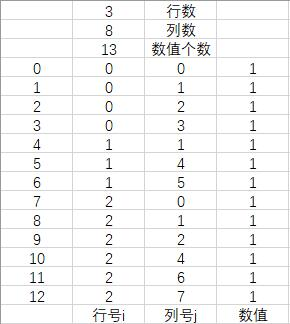

In [13]:
其对应的三元顺序表为

In [117]:
import numpy as np

def sparseMatrix2TripleTable(sMatrix):
    '''将输入的稀疏矩阵转换为三元组'''
    sMatrix = np.array(sMatrix) #转换为numpy的数组类型
    tripleTable = [[0],[0],[0]]
    tripleTable[0][0], tripleTable[1][0] = sMatrix.shape #得到行数、列数
   
    nonZeroIndex = np.nonzero(sMatrix) #得到矩阵非零元素的下标组成的tuple
    
    nonZeroNum = len(nonZeroIndex[0]) #记录非零个数
    tripleTable[2][0] = nonZeroNum 
    
    for i in range(nonZeroNum):
        rowIndex = nonZeroIndex[0][i]
        colIndex = nonZeroIndex[1][i]
        val = sMatrix[rowIndex, colIndex]
        tripleTable.append([rowIndex, colIndex, val])
    return tripleTable
        
tripleTable_test = sparseMatrix2TripleTable(oneHot_test)
tripleTable_test

[[3],
 [8],
 [13],
 [0, 0, 1],
 [0, 1, 1],
 [0, 2, 1],
 [0, 3, 1],
 [1, 1, 1],
 [1, 4, 1],
 [1, 5, 1],
 [2, 0, 1],
 [2, 1, 1],
 [2, 2, 1],
 [2, 4, 1],
 [2, 6, 1],
 [2, 7, 1]]

从上面的输出可以看到，得到稀疏矩阵转三元顺序组的函数实现无误，输出与预期一致。

### 将从semeval得到的one-hot矩阵转换为三元顺序组

In [122]:
tripleTable_semeval = sparseMatrix2TripleTable(oneHot_semeval)
saveDataToFile(tripleTable_semeval, 'smatrix.txt')

## 稀疏矩阵加法运算实现

在实际的应用中，可能会涉及到稀疏矩阵的加法运算（在矩阵的行和列相等的情况下），下面给出一个例子。

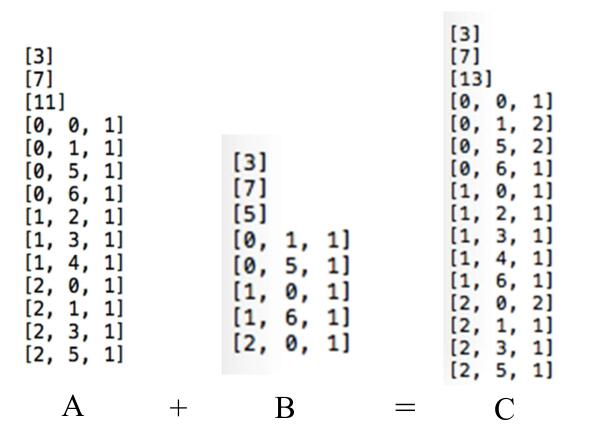

In [18]:
稀疏矩阵例子为

### 代码实现及测试

In [163]:
import numpy as np

def addSparseMatrix(triTable1, triTable2):
    '''两个行和列数相等的稀疏矩阵（以三元顺序组表示）的加法'''
    ans = triTable1
    vistedList = [] #标记访问过的三元组的下标
    
    for i, val1 in enumerate(triTable1[3:]):
        for j, val2 in enumerate(triTable2[3:]):
            #若 j还没有被访问 且 两个矩阵在相同的位置上都有非零元素
            if j not in vistedList and (val1[0], val1[1]) == (val2[0], val2[1]):
                ans[i+3][-1] += val2[-1]
                vistedList.append(j) #标记已访问
    #得到未访问的三元组下标
    unVistedList = [i for i in range(triTable2[2][0]) if i not in vistedList]
    ans[2][0] += len(unVistedList)#更新结果的非零元素个数
    #将第二个
    for i in unVistedList:
        ans.append(triTable2[i+3])
    #将部分结果排好序后再返回
    temp = ans[3:]
    temp.sort(key = lambda x: (x[0],x[1]))
    return ans[:3]+temp

tripleTable_test1 = [[3], [7], [11],
                    [0, 0, 1], [0, 1, 1], [0, 5, 1], [0, 6, 1], [1, 2, 1],
                    [1, 3, 1], [1, 4, 1], [2, 0, 1], [2, 1, 1], [2, 3, 1],
                    [2, 5, 1]]    
tripleTable_test2 = [[3], [7], [5],
                    [0, 1, 1], [0, 5, 1], [1, 0, 1], [1, 6, 1], [2, 0, 1]]

addRes = addSparseMatrix(tripleTable_test1, tripleTable_test2)
addRes

[[3],
 [7],
 [13],
 [0, 0, 1],
 [0, 1, 2],
 [0, 5, 2],
 [0, 6, 1],
 [1, 0, 1],
 [1, 2, 1],
 [1, 3, 1],
 [1, 4, 1],
 [1, 6, 1],
 [2, 0, 2],
 [2, 1, 1],
 [2, 3, 1],
 [2, 5, 1]]

可以看到，结果输出与上面的图片中显示的一致。

# 思考题

---

- 1.IDF的第二条计算公式中分母多了个1是为什么？
    - 答：当词$t_i$不在文档$d_j$的时候，$|j:t_i\in d_j|$为0，即第一条公式的除式的分母为0，因此为了**避免被除数为0**的异常情况，在第二条公式上的分母添加了个1。
    

- 2.IDF数值有什么含义？TF-IDF数值有什么含义？
    - 答：若词T在文档D中的词频越高，那么从某种程度上来讲，可以说词T在文档D中是比较重要的，但是这样的思路有一个bug: 一些对文档来说重要性几乎为0的常用词（或在这个文档集合中经常出现的词）的TF值却很高，而IDF值的出现则可以修复这个bug。
    - 若包含词T的文档数越少，那么词T的IDF值就越高。这就可以用来解决常用词（或在这个文档集合中经常出现的词）TF值高的问题了，因为包含这些词的文档数较多，因此它们对应的IDF值就越小，这样就可以解决TF值衡量词在文档中重要性的bug了。
    - 而将TF值和IDF值对应的相乘就得到一个较为客观的结果——TF-IDF矩阵：可以看到，若某一词语T在某个文档D中有较高的频率（TF值较大），同时该词语在整个文件集合中又有较低的文档频率（IDF值较大），那么对于两者相乘即可得到值较大的的TF-IDF值，从而该词语T可被认为是文件D中的较有代表新的词。因此，通过计算TF-IDF矩阵，我们可以过滤掉常见的词，而保留较重要的词。
    - **因此，IDF的数值代表着词在所有文档的罕见性，在所有文档中，词的罕见程度越高，词对应的IDF数值就越大。TF-IDF矩阵的数值则代表词在对应文档的重要性，数值越高，词在文档中的重要性越高。**
    

- 3.为什么要用三元顺序表表达稀疏矩阵？
    - 答：稀疏矩阵中存在大量的零元素，如果直接将矩阵存储起来就很浪费内存，而用三元组顺序表表达稀疏矩阵则可以**通过只保存矩阵中非零的元素来保存所有的信息，同时使得数据存储的空间大大减少**。
    
# 附录

---

该段代码是平台配置代码，与实验无关，可以pass。

In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image
其对应的三元顺序表为=Image("./images/1.jpg")
稀疏矩阵例子为=Image("./images/2.jpg")